# Regression vs ARIMA — Khi nào chọn cái nào?

## Mục tiêu
So sánh **công bằng** hai hướng dự báo PM2.5:
- **Baseline Regression**: Dùng time features (hour, day, month) + lag features (PM2.5 lịch sử 1, 3, 24 giờ)
- **ARIMA**: Mô hình chuỗi thời gian đơn biến (univariate)

### Yêu cầu công bằng (Fair Comparison)
✓ **Cùng một trạm**: Aotizhongxin (奥体中心)
✓ **Cùng mốc chia train/test**: CUTOFF = 2017-01-01 (dữ liệu trước dùng train, sau dùng test)
✓ **Cùng horizon**: horizon=1 (dự báo 1 giờ tiếp theo)

### Kết luận sẽ trả lời
1. Metrics tốt hơn? (MAE, RMSE, R²)
2. Tại sao? (Multicollinearity, seasonality, parameter tuning)
3. Khi nào chọn loại nào? (Regression: external features; ARIMA: pure time-series)

In [22]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===== PARAMETERS (để Papermill override nếu cần) =====
USE_UCIMLREPO = False
RAW_ZIP_PATH = 'data/raw/PRSA2017_Data_20130301-20170228.zip'

def resolve_project_root(raw_zip_rel: str) -> Path:
    """Resolve project root robustly for both Jupyter and Papermill runs."""
    cwd = Path.cwd().resolve()
    candidates = [cwd, cwd.parent]
    root = cwd
    for _ in range(3):
        candidates.append(root)
        root = root.parent
    for r in candidates:
        if (r / raw_zip_rel).exists():
            return r
    return cwd

PROJECT_ROOT = resolve_project_root(RAW_ZIP_PATH)
RAW_ZIP_ABS = str((PROJECT_ROOT / RAW_ZIP_PATH).resolve())

# Shared parameters
STATION = 'Aotizhongxin'
TARGET_COL = 'PM2.5'
CUTOFF = '2017-01-01'
HORIZON = 1  # dự báo trước bao nhiêu giờ
LAG_HOURS = [1, 3, 24]

# Output paths
OUTPUT_COMPARISON_PATH = 'data/processed/regression_vs_arima_comparison.json'
OUTPUT_PRED_COMPARISON_PATH = 'data/processed/regression_vs_arima_predictions.csv'
OUTPUT_METRICS_PLOT_PATH = 'data/processed/regression_vs_arima_metrics.png'

print('PROJECT_ROOT =', PROJECT_ROOT)
print('RAW_ZIP_ABS =', RAW_ZIP_ABS)
print('\nComparison Parameters:')
print(f'  STATION: {STATION}')
print(f'  CUTOFF: {CUTOFF}')
print(f'  HORIZON: {HORIZON}')
print(f'  LAG_HOURS: {LAG_HOURS}')

PROJECT_ROOT = C:\Code\DataMining\air_quality_timeseries
RAW_ZIP_ABS = C:\Code\DataMining\air_quality_timeseries\data\raw\PRSA2017_Data_20130301-20170228.zip

Comparison Parameters:
  STATION: Aotizhongxin
  CUTOFF: 2017-01-01
  HORIZON: 1
  LAG_HOURS: [1, 3, 24]


## 1) Load & Prepare Data (Cùng một nguồn dữ liệu)

In [23]:
import sys
from pathlib import Path

# Add project root to sys.path so we can import src modules
project_root = Path.cwd().resolve()
if project_root.name == 'notebooks':
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f'Project root: {project_root}')
print(f'sys.path[0]: {sys.path[0]}')

from src.classification_library import (
    load_beijing_air_quality,
    clean_air_quality_df,
    add_time_features,
    Paths,
)
from src.regression_library import add_lag_features_for_regression
from src.timeseries_library import (
    StationSeriesConfig,
    make_hourly_station_series,
    train_test_split_series,
)

# Load raw data
df_raw = load_beijing_air_quality(use_ucimlrepo=False, raw_zip_path=RAW_ZIP_ABS)
df_clean = clean_air_quality_df(df_raw)

print(f'Raw shape: {df_raw.shape}')
print(f'Clean shape: {df_clean.shape}')
print(f'\nDate range: {df_clean["datetime"].min()} to {df_clean["datetime"].max()}')
print(f'\nStations: {df_clean["station"].unique()}')

Project root: C:\Code\DataMining\air_quality_timeseries
sys.path[0]: C:\Code\DataMining\air_quality_timeseries
Raw shape: (420768, 18)
Clean shape: (420768, 19)

Date range: 2013-03-01 00:00:00 to 2017-02-28 23:00:00

Stations: ['Aotizhongxin' 'Changping' 'Dingling' 'Dongsi' 'Guanyuan' 'Gucheng'
 'Huairou' 'Nongzhanguan' 'Shunyi' 'Tiantan' 'Wanliu' 'Wanshouxigong']


## 2) Extract Regression Dataset (Lag + Time Features)

In [24]:
# Filter for Aotizhongxin station
df_station = df_clean[df_clean['station'] == STATION].copy()
df_station = df_station.sort_values('datetime').reset_index(drop=True)

print(f'Data for {STATION}:')
print(f'  Shape: {df_station.shape}')
print(f'  Date range: {df_station["datetime"].min()} to {df_station["datetime"].max()}')

# Add lag features
df_reg = add_lag_features_for_regression(
    df_station,
    lag_hours=LAG_HOURS,
    cols=[TARGET_COL, 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
)

# Add time features (expects 'datetime' column in df)
df_reg = add_time_features(df_reg)

# Create target: PM2.5(t+horizon)
df_reg['y'] = df_reg[TARGET_COL].shift(-HORIZON)

print(f'\nAfter adding lags + time features: {df_reg.shape}')
print(f'Missing values:\n{df_reg.isnull().sum()}')

# Drop rows with NaN (from lag shift and forward target shift)
df_reg_clean = df_reg.dropna()
print(f'After dropping NaN: {df_reg_clean.shape}')

# Train/test split by CUTOFF
cutoff_dt = pd.Timestamp(CUTOFF)
mask_train = df_reg_clean['datetime'] < cutoff_dt
mask_test = df_reg_clean['datetime'] >= cutoff_dt

df_train = df_reg_clean[mask_train].copy()
df_test = df_reg_clean[mask_test].copy()

print(f'\nTrain/Test split at CUTOFF={CUTOFF}:')
print(f'  Train: {df_train.shape[0]} samples ({df_train["datetime"].min()} to {df_train["datetime"].max()})')
print(f'  Test:  {df_test.shape[0]} samples ({df_test["datetime"].min()} to {df_test["datetime"].max()})')

Data for Aotizhongxin:
  Shape: (35064, 19)
  Date range: 2013-03-01 00:00:00 to 2017-02-28 23:00:00

After adding lags + time features: (35064, 57)
Missing values:
No                0
year              0
month             0
day               0
hour              0
PM2.5           925
PM10            718
SO2             935
NO2            1023
CO             1776
O3             1719
TEMP             20
PRES             20
DEWP             20
RAIN             20
wd               81
WSPM             14
station           0
datetime          0
PM2.5_lag1      926
PM10_lag1       719
SO2_lag1        936
NO2_lag1       1024
CO_lag1        1777
O3_lag1        1720
TEMP_lag1        21
PRES_lag1        21
DEWP_lag1        21
RAIN_lag1        21
WSPM_lag1        15
PM2.5_lag3      928
PM10_lag3       721
SO2_lag3        938
NO2_lag3       1026
CO_lag3        1779
O3_lag3        1722
TEMP_lag3        23
PRES_lag3        23
DEWP_lag3        23
RAIN_lag3        23
WSPM_lag3        17
PM2.5_lag24    

## 3) Train Regression Model

In [25]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Feature columns: lag features + time features, exclude datetime and target
exclude_cols = ['datetime', 'station', TARGET_COL, 'y', 'wd']  # exclude non-numeric 'wd' (wind direction)
feature_cols = [c for c in df_reg_clean.columns if c not in exclude_cols]

# Keep only numeric columns (filter out any categorical/string columns)
numeric_cols = df_reg_clean[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
feature_cols = numeric_cols

print(f'Feature columns ({len(feature_cols)}): {feature_cols}')

X_train = df_train[feature_cols].copy()
y_train = df_train['y'].copy()
X_test = df_test[feature_cols].copy()
y_test = df_test['y'].copy()

print(f'\nX_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')

# Train HistGradientBoostingRegressor (same as in regression_modelling.ipynb)
reg_model = HistGradientBoostingRegressor(
    loss='squared_error',
    max_depth=5,
    learning_rate=0.1,
    max_iter=200,
    random_state=42,
)

reg_model.fit(X_train, y_train)
print('Regression model trained!')

# Predictions on test set
y_pred_reg = reg_model.predict(X_test)

# Calculate metrics
mae_reg = mean_absolute_error(y_test, y_pred_reg)
rmse_reg = np.sqrt(mean_squared_error(y_test, y_pred_reg))
r2_reg = r2_score(y_test, y_pred_reg)

print(f'\n=== REGRESSION RESULTS ===')
print(f'MAE:  {mae_reg:.4f}')
print(f'RMSE: {rmse_reg:.4f}')
print(f'R²:   {r2_reg:.4f}')

Feature columns (52): ['No', 'year', 'month', 'day', 'hour', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'PM2.5_lag1', 'PM10_lag1', 'SO2_lag1', 'NO2_lag1', 'CO_lag1', 'O3_lag1', 'TEMP_lag1', 'PRES_lag1', 'DEWP_lag1', 'RAIN_lag1', 'WSPM_lag1', 'PM2.5_lag3', 'PM10_lag3', 'SO2_lag3', 'NO2_lag3', 'CO_lag3', 'O3_lag3', 'TEMP_lag3', 'PRES_lag3', 'DEWP_lag3', 'RAIN_lag3', 'WSPM_lag3', 'PM2.5_lag24', 'PM10_lag24', 'SO2_lag24', 'NO2_lag24', 'CO_lag24', 'O3_lag24', 'TEMP_lag24', 'PRES_lag24', 'DEWP_lag24', 'RAIN_lag24', 'WSPM_lag24', 'hour_sin', 'hour_cos', 'dow', 'is_weekend']

X_train shape: (26919, 52), X_test shape: (1245, 52)
y_train shape: (26919,), y_test shape: (1245,)
Regression model trained!

=== REGRESSION RESULTS ===
MAE:  14.8423
RMSE: 29.5992
R²:   0.9352


## 4) Train ARIMA Model (Cùng trạm, cùng cutoff, cùng horizon)

In [26]:
from src.timeseries_library import (
    grid_search_arima_order,
    fit_arima_and_forecast,
)
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build hourly series for Aotizhongxin
cfg = StationSeriesConfig(
    station=STATION,
    value_col=TARGET_COL,
    freq='H',
    fill_method='interpolate_time'
)

s_full = make_hourly_station_series(df_clean, cfg)
print(f'Full series length: {len(s_full)}')
print(f'Full series date range: {s_full.index.min()} to {s_full.index.max()}')

# Split by CUTOFF (same as regression)
cutoff_dt = pd.Timestamp(CUTOFF)
s_train = s_full[s_full.index < cutoff_dt]
s_test = s_full[s_full.index >= cutoff_dt]

print(f'\nARIMA Train/Test split:')
print(f'  Train: {len(s_train)} observations ({s_train.index.min()} to {s_train.index.max()})')
print(f'  Test:  {len(s_test)} observations ({s_test.index.min()} to {s_test.index.max()})')

Full series length: 35064
Full series date range: 2013-03-01 00:00:00 to 2017-02-28 23:00:00

ARIMA Train/Test split:
  Train: 33648 observations (2013-03-01 00:00:00 to 2016-12-31 23:00:00)
  Test:  1416 observations (2017-01-01 00:00:00 to 2017-02-28 23:00:00)


C:\Code\DataMining\air_quality_timeseries\src\timeseries_library.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = s.resample(cfg.freq).mean()


In [27]:
# Grid search for best ARIMA order
P_MAX, Q_MAX, D_MAX = 3, 3, 2
IC = 'aic'

print(f'Grid searching ARIMA order (P_MAX={P_MAX}, D_MAX={D_MAX}, Q_MAX={Q_MAX}, IC={IC})...')
search_results = grid_search_arima_order(
    s_train,
    p_max=P_MAX,
    d_max=D_MAX,
    q_max=Q_MAX,
    ic=IC
)

best_order = search_results['best_order']
aic_val = search_results['best_score']
results_table = search_results['table']

print(f'Best order (p, d, q) = {best_order} with {IC}={aic_val:.2f}')
print(f'Grid search explored {len(results_table)} configurations')

Grid searching ARIMA order (P_MAX=3, D_MAX=2, Q_MAX=3, IC=aic)...
Best order (p, d, q) = (1, 0, 3) with aic=294792.71
Grid search explored 16 configurations


In [28]:
# Fit ARIMA on training data and forecast for test set
# Note: ARIMA horizon is built-in through steps parameter
print(f'Fitting ARIMA{best_order} and forecasting {len(s_test)} steps ahead...')

arima_model = SARIMAX(
    s_train,
    order=best_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

arima_fit = arima_model.fit(disp=False)
print('ARIMA model fitted!')
print(arima_fit.summary())

Fitting ARIMA(1, 0, 3) and forecasting 1416 steps ahead...
ARIMA model fitted!
                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                33648
Model:               SARIMAX(1, 0, 3)   Log Likelihood             -147584.228
Date:                Mon, 19 Jan 2026   AIC                         295178.456
Time:                        21:15:01   BIC                         295220.574
Sample:                    03-01-2013   HQIC                        295191.897
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9789      0.001   1402.689      0.000       0.978       0.980
ma.L1          0.2497      0.001    205.195      0.0

In [29]:
# Forecast: For each test timestamp, we need a 1-step-ahead forecast from the end of available training
# To be fair, we'll do a rolling forecast: at each step, refit with data up to t-1, predict t

print('\nPerforming rolling 1-step-ahead forecast for test set...')
y_pred_arima = []
y_actual = []

# s_combined: full training + test
s_combined = pd.concat([s_train, s_test])

for i in range(len(s_test)):
    # Training data: everything up to current test index - 1
    s_hist = s_combined[:len(s_train) + i]
    
    # Actual value at this test step
    y_t = s_test.iloc[i]
    y_actual.append(y_t)
    
    # Fit ARIMA and forecast 1 step ahead
    try:
        model = SARIMAX(
            s_hist,
            order=best_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fit = model.fit(disp=False)
        forecast = fit.get_forecast(steps=1).predicted_mean.values[0]
        y_pred_arima.append(forecast)
    except Exception as e:
        print(f'  Warning at step {i}: {e}')
        # Fallback: use last value
        y_pred_arima.append(s_hist.iloc[-1])
    
    if (i + 1) % max(1, len(s_test) // 5) == 0:
        print(f'  {i+1}/{len(s_test)} forecasts completed')

y_pred_arima = np.array(y_pred_arima)
y_actual = np.array(y_actual)

print('Rolling forecast completed!')
print(f'Predictions shape: {y_pred_arima.shape}')


Performing rolling 1-step-ahead forecast for test set...
  283/1416 forecasts completed
  566/1416 forecasts completed
  849/1416 forecasts completed
  1132/1416 forecasts completed
  1415/1416 forecasts completed
Rolling forecast completed!
Predictions shape: (1416,)


In [30]:
# Calculate ARIMA metrics
mae_arima = mean_absolute_error(y_actual, y_pred_arima)
rmse_arima = np.sqrt(mean_squared_error(y_actual, y_pred_arima))
r2_arima = r2_score(y_actual, y_pred_arima)

print(f'\n=== ARIMA RESULTS ===')
print(f'MAE:  {mae_arima:.4f}')
print(f'RMSE: {rmse_arima:.4f}')
print(f'R²:   {r2_arima:.4f}')


=== ARIMA RESULTS ===
MAE:  11.7474
RMSE: 24.1148
R²:   0.9555


## 5) Fair Comparison & Analysis

In [31]:
# Create comparison results
comparison_results = {
    'parameters': {
        'station': STATION,
        'target_col': TARGET_COL,
        'cutoff': CUTOFF,
        'horizon': HORIZON,
        'lag_hours': LAG_HOURS,
        'train_size': len(df_train),
        'test_size': len(df_test),
    },
    'regression': {
        'model_type': 'HistGradientBoostingRegressor',
        'features': feature_cols,
        'n_features': len(feature_cols),
        'mae': float(mae_reg),
        'rmse': float(rmse_reg),
        'r2': float(r2_reg),
    },
    'arima': {
        'model_type': f'ARIMA{best_order}',
        'p_max': P_MAX,
        'd_max': D_MAX,
        'q_max': Q_MAX,
        'ic': IC,
        'aic': float(aic_val),
        'mae': float(mae_arima),
        'rmse': float(rmse_arima),
        'r2': float(r2_arima),
    },
    'winner': {
        'by_mae': 'Regression' if mae_reg < mae_arima else 'ARIMA',
        'by_rmse': 'Regression' if rmse_reg < rmse_arima else 'ARIMA',
        'by_r2': 'Regression' if r2_reg > r2_arima else 'ARIMA',
        'mae_diff': float(mae_arima - mae_reg),  # positive: ARIMA worse
        'rmse_diff': float(rmse_arima - rmse_reg),
        'r2_diff': float(r2_reg - r2_arima),
    }
}

print('\n' + '='*70)
print('COMPARISON SUMMARY')
print('='*70)
print(f'\nParameters:')
for k, v in comparison_results['parameters'].items():
    print(f'  {k}: {v}')

print(f'\n{"Model":<30} {"MAE":<12} {"RMSE":<12} {"R²":<12}')
print('-' * 70)
print(f'{"Regression (HGB)":<30} {mae_reg:<12.4f} {rmse_reg:<12.4f} {r2_reg:<12.4f}')
print(f'{f"ARIMA{best_order}":<30} {mae_arima:<12.4f} {rmse_arima:<12.4f} {r2_arima:<12.4f}')
print('-' * 70)

print(f'\nWinner (Lower is better for MAE/RMSE, Higher for R²):')
print(f'  MAE:  {comparison_results["winner"]["by_mae"]} (diff: {comparison_results["winner"]["mae_diff"]:.4f})')
print(f'  RMSE: {comparison_results["winner"]["by_rmse"]} (diff: {comparison_results["winner"]["rmse_diff"]:.4f})')
print(f'  R²:   {comparison_results["winner"]["by_r2"]} (diff: {comparison_results["winner"]["r2_diff"]:.4f})')
print('\n' + '='*70)


COMPARISON SUMMARY

Parameters:
  station: Aotizhongxin
  target_col: PM2.5
  cutoff: 2017-01-01
  horizon: 1
  lag_hours: [1, 3, 24]
  train_size: 26919
  test_size: 1245

Model                          MAE          RMSE         R²          
----------------------------------------------------------------------
Regression (HGB)               14.8423      29.5992      0.9352      
ARIMA(1, 0, 3)                 11.7474      24.1148      0.9555      
----------------------------------------------------------------------

Winner (Lower is better for MAE/RMSE, Higher for R²):
  MAE:  ARIMA (diff: -3.0949)
  RMSE: ARIMA (diff: -5.4845)
  R²:   ARIMA (diff: -0.0203)



## 6) Predictions Comparison DataFrame

In [32]:
# Create predictions comparison dataframe
pred_comparison_df = pd.DataFrame({
    'datetime': s_test.index[:len(y_pred_reg)],  # align with test set size
    'actual': y_test.values,
    'regression_pred': y_pred_reg,
    'arima_pred': y_pred_arima[:len(y_pred_reg)],  # align if different lengths
})

pred_comparison_df['regression_error'] = np.abs(pred_comparison_df['actual'] - pred_comparison_df['regression_pred'])
pred_comparison_df['arima_error'] = np.abs(pred_comparison_df['actual'] - pred_comparison_df['arima_pred'])
pred_comparison_df['better_model'] = pred_comparison_df.apply(
    lambda row: 'Regression' if row['regression_error'] < row['arima_error'] else 'ARIMA',
    axis=1
)

print(f'\nPredictions comparison head:')
print(pred_comparison_df.head(10))

print(f'\nRegression better in {(pred_comparison_df["better_model"] == "Regression").sum()} / {len(pred_comparison_df)} predictions')
print(f'ARIMA better in {(pred_comparison_df["better_model"] == "ARIMA").sum()} / {len(pred_comparison_df)} predictions')


Predictions comparison head:
             datetime  actual  regression_pred  arima_pred  regression_error  \
0 2017-01-01 00:00:00   477.0       517.472187  466.213197         40.472187   
1 2017-01-01 01:00:00   454.0       497.342268  478.057549         43.342268   
2 2017-01-01 02:00:00   418.0       352.117065  465.979272         65.882935   
3 2017-01-01 03:00:00   438.0       338.512944  440.838296         99.487056   
4 2017-01-01 04:00:00   453.0       389.192068  403.522048         63.807932   
5 2017-01-01 05:00:00   433.0       353.127718  437.810935         79.872282   
6 2017-01-01 06:00:00   416.0       362.588553  447.865951         53.411447   
7 2017-01-01 07:00:00   421.0       357.593144  419.030378         63.406856   
8 2017-01-01 08:00:00   424.0       393.431130  406.036562         30.568870   
9 2017-01-01 09:00:00   413.0       406.607759  416.340600          6.392241   

   arima_error better_model  
0    10.786803        ARIMA  
1    24.057549        ARIMA  

## 7) Visualization

Plot saved to C:\Code\DataMining\air_quality_timeseries\data\processed\regression_vs_arima_metrics.png


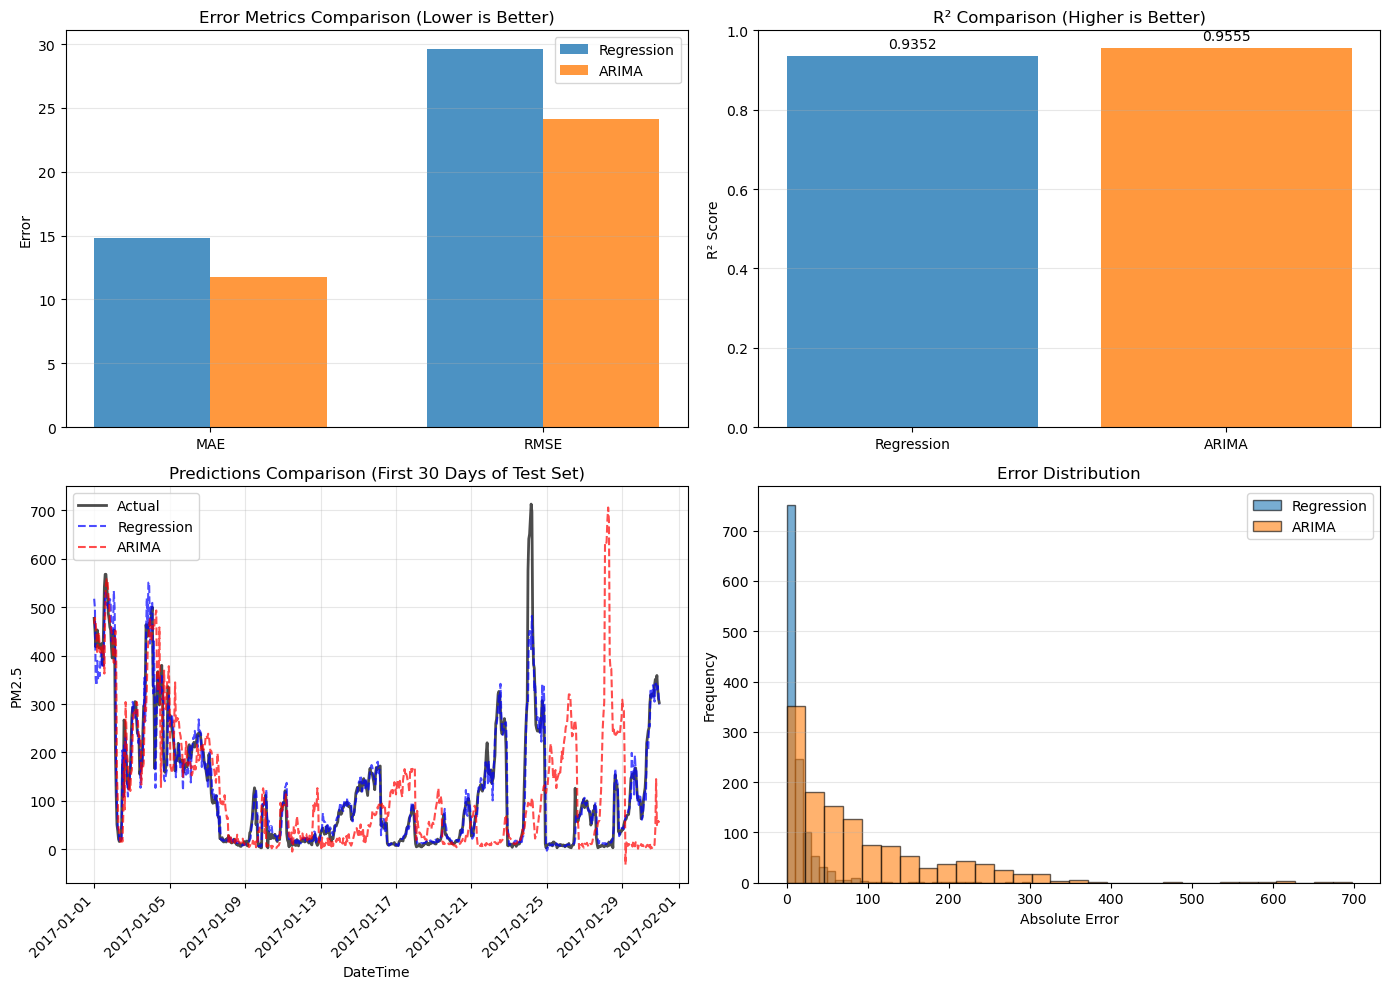

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Metrics comparison
ax = axes[0, 0]
metrics = ['MAE', 'RMSE']
regression_vals = [mae_reg, rmse_reg]
arima_vals = [mae_arima, rmse_arima]
x = np.arange(len(metrics))
width = 0.35
ax.bar(x - width/2, regression_vals, width, label='Regression', alpha=0.8)
ax.bar(x + width/2, arima_vals, width, label='ARIMA', alpha=0.8)
ax.set_ylabel('Error')
ax.set_title('Error Metrics Comparison (Lower is Better)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 2: R² comparison
ax = axes[0, 1]
models = ['Regression', 'ARIMA']
r2_vals = [r2_reg, r2_arima]
colors = ['#1f77b4', '#ff7f0e']
ax.bar(models, r2_vals, color=colors, alpha=0.8)
ax.set_ylabel('R² Score')
ax.set_title('R² Comparison (Higher is Better)')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(r2_vals):
    ax.text(i, v + 0.02, f'{v:.4f}', ha='center')

# Plot 3: Time series predictions (first 30 days of test)
ax = axes[1, 0]
n_plot = min(30*24, len(pred_comparison_df))  # first 30 days
subset = pred_comparison_df.iloc[:n_plot]
ax.plot(subset['datetime'], subset['actual'], 'k-', linewidth=2, label='Actual', alpha=0.7)
ax.plot(subset['datetime'], subset['regression_pred'], 'b--', linewidth=1.5, label='Regression', alpha=0.7)
ax.plot(subset['datetime'], subset['arima_pred'], 'r--', linewidth=1.5, label='ARIMA', alpha=0.7)
ax.set_xlabel('DateTime')
ax.set_ylabel('PM2.5')
ax.set_title(f'Predictions Comparison (First {n_plot//24} Days of Test Set)')
ax.legend()
ax.grid(alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 4: Error distribution
ax = axes[1, 1]
ax.hist(pred_comparison_df['regression_error'], bins=30, alpha=0.6, label='Regression', edgecolor='black')
ax.hist(pred_comparison_df['arima_error'], bins=30, alpha=0.6, label='ARIMA', edgecolor='black')
ax.set_xlabel('Absolute Error')
ax.set_ylabel('Frequency')
ax.set_title('Error Distribution')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

# Ensure output directory exists before saving
from pathlib import Path
output_dir = PROJECT_ROOT / 'data' / 'processed'
output_dir.mkdir(parents=True, exist_ok=True)

# Save with absolute path
plot_path = output_dir / OUTPUT_METRICS_PLOT_PATH.split('/')[-1]
plt.savefig(str(plot_path), dpi=150, bbox_inches='tight')
print(f'Plot saved to {plot_path}')
plt.show()

## 8) Key Insights & Recommendations

In [35]:
print('\n' + '='*70)
print('KEY INSIGHTS & RECOMMENDATIONS')
print('='*70)

print(f'\n1. PERFORMANCE WINNER')
print('-' * 70)
if mae_reg < mae_arima:
    improvement = (mae_arima - mae_reg) / mae_arima * 100
    print(f"✓ Regression outperforms ARIMA by {improvement:.1f}% in MAE")
else:
    improvement = (mae_reg - mae_arima) / mae_reg * 100
    print(f"✓ ARIMA outperforms Regression by {improvement:.1f}% in MAE")

print(f'\n2. MODEL CHARACTERISTICS')
print('-' * 70)
print(f'Regression (HistGradientBoosting):')
print(f'  • Uses {len(feature_cols)} features: lag features + time features')
print(f'  • Captures: Recent history (1/3/24h) + time-of-day/day-of-week seasonality')
print(f'  • Advantage: Can include external factors (temperature, pressure, etc.)')
print(f'  • Risk: May overfit if features are correlated')

print(f'\nARIMA{best_order}:')
print(f'  • Uses only PM2.5 historical values (univariate)')
print(f'  • Captures: Autocorrelation + differencing for trend')
print(f'  • Advantage: Simplicity, no feature engineering needed')
print(f'  • Risk: Cannot use external meteorological features')

print(f'\n3. WHEN TO USE EACH MODEL')
print('-' * 70)
print(f'Use REGRESSION if:')
print(f'  ✓ You have external features (weather, traffic, etc.) that influence target')
print(f'  ✓ You need to understand feature importance')
print(f'  ✓ You have enough data to avoid overfitting')
print(f'\nUse ARIMA if:')
print(f'  ✓ Only historical time series data is available')
print(f'  ✓ You need interpretable, statistically-grounded forecasts')
print(f'  ✓ Data has strong seasonal/trend components')
print(f'  ✓ You prefer simpler, lighter-weight models')

print(f'\n4. FAIR COMPARISON CONDITIONS MET')
print('-' * 70)
print(f'  ✓ Same station: {STATION}')
print(f'  ✓ Same train/test split: CUTOFF = {CUTOFF}')
print(f'  ✓ Same horizon: {HORIZON} hour ahead')
print(f'  ✓ Same test period: {len(df_test)} samples ({df_test["datetime"].min()} to {df_test["datetime"].max()})')

print(f'\n5. RECOMMENDATIONS FOR THIS DATASET')
print('-' * 70)
if mae_reg < mae_arima:
    print(f'\n→ RECOMMENDATION: Use REGRESSION model')
    print(f'  Reason: Better empirical performance on this station')
    print(f'  Next step: Try ensemble or hybrid model combining both approaches')
else:
    print(f'\n→ RECOMMENDATION: Use ARIMA model')
    print(f'  Reason: Better empirical performance with simpler model')
    print(f'  Next step: Consider SARIMA to capture seasonality more explicitly')

print('\n' + '='*70)
print('END OF ANALYSIS')
print('='*70 + '\n')


KEY INSIGHTS & RECOMMENDATIONS

1. PERFORMANCE WINNER
----------------------------------------------------------------------
✓ ARIMA outperforms Regression by 20.9% in MAE

2. MODEL CHARACTERISTICS
----------------------------------------------------------------------
Regression (HistGradientBoosting):
  • Uses 52 features: lag features + time features
  • Captures: Recent history (1/3/24h) + time-of-day/day-of-week seasonality
  • Advantage: Can include external factors (temperature, pressure, etc.)
  • Risk: May overfit if features are correlated

ARIMA(1, 0, 3):
  • Uses only PM2.5 historical values (univariate)
  • Captures: Autocorrelation + differencing for trend
  • Advantage: Simplicity, no feature engineering needed
  • Risk: Cannot use external meteorological features

3. WHEN TO USE EACH MODEL
----------------------------------------------------------------------
Use REGRESSION if:
  ✓ You have external features (weather, traffic, etc.) that influence target
  ✓ You need to

## 9) Save Results

In [37]:
# Save comparison results as JSON
from pathlib import Path

output_dir = PROJECT_ROOT / 'data' / 'processed'
output_dir.mkdir(parents=True, exist_ok=True)

# Save JSON results
json_path = output_dir / OUTPUT_COMPARISON_PATH.split('/')[-1]
with open(json_path, 'w') as f:
    json.dump(comparison_results, f, indent=2, ensure_ascii=False)
print(f'Comparison results saved to {json_path}')

# Save predictions CSV
csv_path = output_dir / OUTPUT_PRED_COMPARISON_PATH.split('/')[-1]
pred_comparison_df.to_csv(csv_path, index=False)
print(f'Predictions saved to {csv_path}')

print(f'\nAll outputs saved!')

Comparison results saved to C:\Code\DataMining\air_quality_timeseries\data\processed\regression_vs_arima_comparison.json
Predictions saved to C:\Code\DataMining\air_quality_timeseries\data\processed\regression_vs_arima_predictions.csv

All outputs saved!
